### TS with LSTM, ref: pag.270 Brownlee

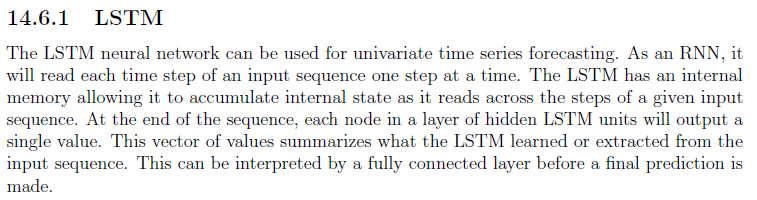

In [1]:
from IPython.display import Image
Image(".\pics\LSTM_forecast_fundament.PNG", width=3, height=5)

In [2]:
import tensorflow

gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tensorflow.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tensorflow.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame, concat, read_csv
from sklearn.metrics import mean_squared_error
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from matplotlib import pyplot
import pandas as pd 

In [4]:
#data source: https://datasetsearch.research.google.com/search?query=univariate%20time%20series&docid=Z2B66b7T3lUIl0y6AAAAAA%3D%3D&filters=bm9uZQ%3D%3D&property=aXNfYWNjZXNzaWJsZV9mb3JfZnJlZQ%3D%3D
ev_sales_data = read_csv(r'.\datasets\china_electric_vehicles_sales.csv')

ev_sales_data['Date'] = pd.to_datetime(ev_sales_data['Year/Month'])
ev_sales_data.set_index('Date', inplace=True)
ev_sales_data.drop(columns=['Year/Month'], inplace=True)

sales_series_values = ev_sales_data['sales'].values
ev_sales_data.head(5)

,BEV,sales
Date,,
2011-01-01,588,310
2011-02-01,47,417
2011-03-01,159,286
2011-04-01,173,162
2011-05-01,305,470


In [5]:
ev_sales_data['year'] = pd.Series(ev_sales_data.index).apply(lambda x: x.year).values
ev_sales_data['month'] = pd.Series(ev_sales_data.index).apply(lambda x: x.month).values
ev_sales_data.head(5)

,BEV,sales,year,month
Date,,,,
2011-01-01,588,310,2011,1
2011-02-01,47,417,2011,2
2011-03-01,159,286,2011,3
2011-04-01,173,162,2011,4
2011-05-01,305,470,2011,5


In [6]:
def make_line_plots(title, dataset, attributes_to_plot=[], x_axis_label='x', y_axis_label='y', 
                        background_color=None, legend_location="top_left", line_colors=['red'],
                        x_axis_type=None, tools = "pan,wheel_zoom,box_zoom,reset"):
        try:
            from bokeh.plotting import figure, show, output_file
            from bokeh.models import HoverTool
            from bokeh.io import output_notebook

            output_notebook()

            p = figure(title=title, x_axis_type=x_axis_type, tools=tools, background_fill_color=background_color)
            p.legend.location = legend_location

            #x_values = dataset.index
            x_values = pd.to_datetime(dataset.index)
            i = 0
            for attribute in attributes_to_plot:
                    attribute_values = dataset[attribute]
                    p.line(x_values, attribute_values, legend=attribute, line_dash=[4, 4], line_color=line_colors[i], 
                            line_width=2)
                    i += 1


            p.y_range.start = 0
            p.legend.location = legend_location
            p.legend.background_fill_color = background_color
            p.xaxis.axis_label = x_axis_label
            p.yaxis.axis_label = y_axis_label
            p.grid.grid_line_color="white"

            p.add_tools(HoverTool())
            p.select_one(HoverTool).tooltips = [
                                    (x_axis_label, '@x'),
                                    (y_axis_label, '@y'),
                                ]
                                
            p.legend.click_policy="hide"

            show(p)

        except Exception as exc:
            return exc
            #logger.exception('raised exception at {}: {}'.format(logger.name+'.'+make_line_plots.__name__, exc))


In [7]:
make_line_plots('EV monthly sales', ev_sales_data, attributes_to_plot=['sales'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue'], x_axis_type="datetime")



Loading BokehJS ...

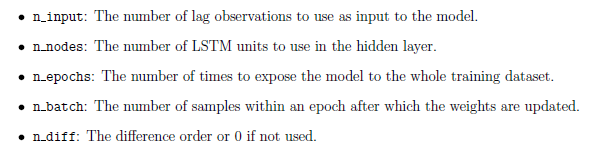

In [8]:
from IPython.display import Image
Image(".\pics\LSTM_TS_hyperparams.PNG", width=3, height=5)

In [9]:
DataFrame(ev_sales_data).head(5)

,BEV,sales,year,month
Date,,,,
2011-01-01,588,310,2011,1
2011-02-01,47,417,2011,2
2011-03-01,159,286,2011,3
2011-04-01,173,162,2011,4
2011-05-01,305,470,2011,5


In [10]:
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values

supervised_data = series_to_supervised(ev_sales_data['sales'], n_in=5, n_out=1)
supervised_data[0]

array([310., 417., 286., 162., 470., 273.])

In [11]:
DataFrame(supervised_data).head(6)

,0,1,2,3,4,5
0,310.0,417.0,286.0,162.0,470.0,273.0
1,417.0,286.0,162.0,470.0,273.0,650.0
2,286.0,162.0,470.0,273.0,650.0,1323.0
3,162.0,470.0,273.0,650.0,1323.0,688.0
4,470.0,273.0,650.0,1323.0,688.0,663.0
5,273.0,650.0,1323.0,688.0,663.0,896.0


In [12]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-int(n_test)], data[-int(n_test):]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset TO MAKE THE SERIES STATIONARY:
'''
make the data stationery by performing a seasonal adjustment, that is subtracting the value
from one year ago from each observation.
'''
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]


# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)

    return error, predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    predictions_matrix = []
    scores = []
    #scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    for _ in range(n_repeats):
        score, predictions = walk_forward_validation(data, n_test, config) 
        scores.append(score)
        predictions_matrix.append(predictions)
    
    return scores, predictions_matrix

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()



In [13]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff
config = [6, 30, 100, 100, 4]
# grid search
scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)

> 2884.623
 > 2333.656
 > 2558.762
 > 2217.404
 > 3259.102
 > 2542.327
 > 2516.631
 > 2275.586
 > 3363.714
 > 3281.283
 > 3155.794
 > 3781.063
 > 2674.022
 > 2875.703
 > 3252.306
 > 3480.796
 > 2977.962
 > 3334.848
 > 1798.505
 > 2803.781
 > 2573.651
 > 2852.603
 > 2573.408
 > 3881.908
 > 2836.554
 > 2767.772
 > 2608.775
 > 2597.449
 > 2775.012
 > 3821.640


LSTM: 2888.555 RMSE (+/- 485.406)


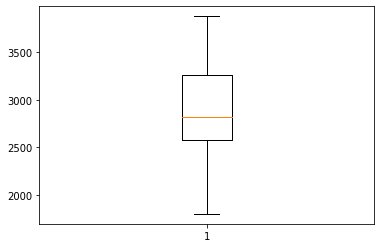

In [14]:
# summarize scores
summarize_scores('LSTM', scores)

In [25]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff
config = [10, 30, 100, 100, 4]
# grid search
scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)

> 2423.079
 > 2195.293
 > 3189.436
 > 2884.840
 > 3866.833
 > 2217.449
 > 2247.350
 > 3074.385
 > 5271.556
 > 2606.811
 > 1838.989
 > 2257.681
 > 2878.500
 > 3456.489
 > 2372.029
 > 2806.014
 > 2613.550
 > 2037.581
 > 2322.624
 > 2425.901
 > 3141.546
 > 2659.386
 > 2155.633
 > 2875.312
 > 2444.644
 > 2730.163
 > 2869.219
 > 2374.344
 > 2759.286
 > 3062.320


LSTM: 2735.275 RMSE (+/- 640.620)


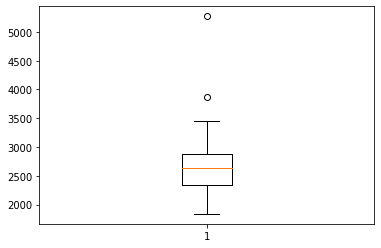

In [26]:
# summarize scores
summarize_scores('LSTM', scores)

In [42]:
ev_sales_forecast_df = pd.DataFrame()

test_rmse = measure_rmse(ev_sales_data['sales'][-n_test:].values, predictions_matrix[-1])
if int(test_rmse) == int(scores[-1]): 
    ev_sales_forecast_df['sales_test_values'] = ev_sales_data['sales'][-n_test:]
    ev_sales_forecast_df['sales_LSTM_predictions'] = [x.numpy()[0] for x in predictions_matrix[-1]] #predictions_matrix[-1]

ev_sales_forecast_df

,sales_test_values,sales_LSTM_predictions
Date,,
2015-03-01,4079,5345.026855
2015-04-01,5730,8271.297852
2015-05-01,6354,2302.346436
2015-06-01,8308,6669.817871
2015-07-01,7338,4475.610840
2015-08-01,12085,8392.653320
2015-09-01,12736,7179.442871
2015-10-01,11384,9176.629883
2015-11-01,11402,8983.105469


In [43]:
make_line_plots('EV monthly sales predictions', ev_sales_forecast_df, attributes_to_plot=['sales_test_values', 'sales_LSTM_predictions'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue', 'red'], x_axis_type="datetime")

Loading BokehJS ...

In [48]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff
config = [12, 30, 100, 100, 12]
# grid search
scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)

> 4983.788
 > 4482.503
 > 3651.499
 > 4511.224
 > 6727.663
 > 6327.240
 > 7409.864
 > 2204.972
 > 3758.540
 > 2539.412
 > 4642.623
 > 3326.857
 > 6028.916
 > 3237.552
 > 2923.613
 > 7075.517
 > 4068.839
 > 2656.117
 > 5674.194
 > 2317.609
 > 2213.107
 > 5010.310
 > 1682.573
 > 4501.502
 > 3204.296
 > 1695.783
 > 4654.414
 > 3183.055
 > 5939.809
 > 4155.684


LSTM: 4159.636 RMSE (+/- 1581.165)


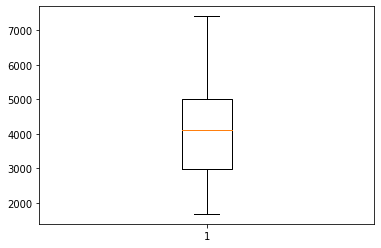

In [49]:
# summarize scores
summarize_scores('LSTM', scores)

In [50]:
ev_sales_forecast_df = pd.DataFrame()

test_rmse = measure_rmse(ev_sales_data['sales'][-n_test:].values, predictions_matrix[-1])
if int(test_rmse) == int(scores[-1]): 
    ev_sales_forecast_df['sales_test_values'] = ev_sales_data['sales'][-n_test:]
    ev_sales_forecast_df['sales_LSTM_predictions'] = [x.numpy()[0] for x in predictions_matrix[-1]] #predictions_matrix[-1]

ev_sales_forecast_df

,sales_test_values,sales_LSTM_predictions
Date,,
2015-03-01,4079,8066.899414
2015-04-01,5730,4774.605469
2015-05-01,6354,3708.968262
2015-06-01,8308,5756.530273
2015-07-01,7338,8229.980469
2015-08-01,12085,9781.034180
2015-09-01,12736,13773.516602
2015-10-01,11384,13598.571289
2015-11-01,11402,14082.780273


In [51]:
make_line_plots('EV monthly sales predictions', ev_sales_forecast_df, attributes_to_plot=['sales_test_values', 'sales_LSTM_predictions'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue', 'red'], x_axis_type="datetime")

Loading BokehJS ...

## COMPROBAR A HACER UNA MEJOR DIFFERENCING Y N_INPUT; JUGAR CON LA RELU  